# How many to make a crowd wise?


If you average a large number of independent estimates, the result is often quite accurate. This notion was popularized in James Surowiecki’s book "The Wisdom of Crowds". But how big of a crowd do you need? I examine the relationship between crowd size and task difficulty using empirical data collected from 94,577 respondants performing twenty tasks of varying difficulty.  

## Research Question
Difficult tasks should require bigger crowds than easy tasks. Can we model the relationship between task difficulty and crowd size using empirical data?
#### Hypothesized relationship between task difficulty, group size, and accuracy
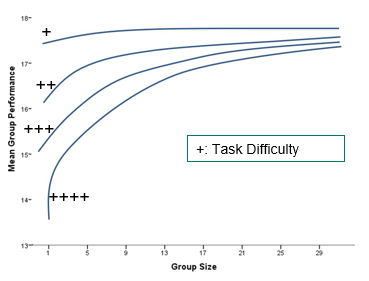



## Data Description
Participants distinguish genuine smiles from forced smiles in online survey
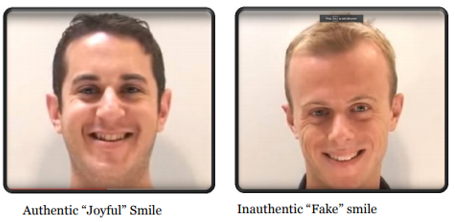

https://www.surveymonkey.com/r/SmileRead

-20 "Smile Videos” total

-95k have accessed survey (n =  94,577)

-64k completed the survey (n = 64,427)

-Posted on SurveyMonkey 



In [1]:
## Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Data Extract, Transform, Load
The block below extracts the raw data file "Spot_the_Fake_Smile_v.3.csv".

It conducts the following transformations:
-It selects only key variables(columns) of data
-It eliminates rows where the survey was not completed.
-It renames the columns
-It saves this data as "Clean_Smile_Data.csv"

It saves the file as 'Clean_Smile_Data.csv'
Variable Description for Output File 'Clean_Smile_Data.csv':
Subject:  Individual Subject ID number. Used as index.
Confidence: How many out of 20 smile videos do you think you'll get?
Is_Femane: 'Female' if selected. 'NaN' if Male or no choice entered
Is_Male: 'Male' if selected. 'NaN' if Female or no choice entered     
Age: Age entered. NaN if not entered.
Children: # of children reported by participant. NaN if not entered.
Career: Reported years in a career that 'required you read people'
Q01-Q20: If answered correctly, it will say 'Genuine' or 'Fake' (which
is the correct answer for the given question). If answered incorrectly,
it will say NaN. All non-answers are filtered out of cleaned data.

In [2]:
## ETL
# Let's open the file
df_input = pd.read_csv('Spot the Fake Smile v.3.csv', header=None, 
    skiprows=(0,1), 
    usecols=[0,9,10,11,12,28,29,30,33,35,37,38,40,43,44,47,48,50,53,55,57,58,60,62,65,66,68,69],
        low_memory=False)
df_input.columns=['Subject','Confidence','Is_Female','Is_Male','Age','Children',
                  'Career','Q01','Q02','Q03','Q04','Q05','Q06','Q07','Q08','Q09',
                  'Q10','Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18',
                  'Q19','Q20_wrong','Q20']
df_input.set_index('Subject', inplace=True)
df_input.head()

#Let's filter out people who didn't finish the whole survey
# Mark people who didn't answer last question (True: Finished survey)
finish = (df_input.iloc[:,25]=='Genuine')|(df_input.iloc[:,26]=='Fake')
# Create a new dataframe containing only people who answerd last question
df_clean = df_input[finish]
# Now we don't need the 'Q20_wrong' variable anymore.
# (we just used it to filter out those who didn't answer the last question)
df_clean = df_clean.drop(columns=['Q20_wrong'])

# Now let's save the cleaned data
df_clean.to_csv('Clean_Smile_Data.csv')


### Creating Nominal Groups
This section combines random individual answers to generate nominal groups from a 
dataset of a desired size. This program inputs the file Clean_Smile_Data.csv.  
The user designates
1) What question do you want to use (there are 20 smile videos to choose from) 
2) How big do you want to make your simulated virtual group?
3) How many groups do you want to generate?
It outputs the accuracy rates of the groups generated. It saves this data to 
a .csv file titled 'Nominal_Group_Data.csv' The file contains 3 variables: 
sample_performance: each data point is a sample of groups. The sample
    performance is the average performance of all the groups in that sample.
difficulty: This is the difficulty of the individual video, defined as 
    the average individual accuracy for the entire 60,000+ responses.
group_size: number of individuals randoly put into a given group   

@author: James Kajdasz

In [3]:
def individual_answer(q):
    '''This function returns the overall mean accuracy for a particular 
    smile video Q.'''
    accuracy = df[q].count() / len(df) * 100
    return round(accuracy, 2)     

def group_answer(q, group_size):
    '''This function takes the smile video (q) and generates a simulated random
    group of size (group_size). It returns the group's collective answer 
    of the video. Returns 0 if group was incorrect, 1 if group was correct
    ''' 
    # find end of list
    end = int(len(df)-1)
    # create a random group of size (group_size)
    group = df.iloc[np.random.randint(0, end, group_size), :]    
    
    # did majority of group get video correct?
    vote = group[q].count()
    if vote > (len(group)/2):
        # the group got the right answer
        return 1
    elif vote == (len(group)/2):
        # the group is tied
        return 0.5
    else:
        # the group got the wrong answer
        return 0    

def sample_answer(q, group_size, sample_size):
    '''This function takes the smile video 'q', the group size (group_size), 
    and generates (sample_size) number of groups. It returns the average accuracy 
    rate of the groups in the sample
    '''    
    i = sample_size
    group_answers = []
    while i > 0:
        answer = group_answer(q, group_size)
        group_answers.append(answer)
        i -= 1
    return (100*np.mean(group_answers)) 

def repeat_samples(q, group_size, sample_size, num_samples):
    ''' This procedure will repeat the sampling process (sample_answer) for 
    a desired number of times (num_samples). It returns a list of how each 
    sample performed on the task.
    '''
    j = num_samples
    accuracy_samples = []
    while j > 0:
        sample = sample_answer(q, group_size, sample_size)
        accuracy_samples.append(sample)
        j -= 1
    np_accuracy_samples = np.array(accuracy_samples)
    return np_accuracy_samples

def col_nam(n):
    '''This function takes an integer n and out puts the appropriate name of 
    one of the smile_video columns. Ex: in 3. Out: 'Q03'
    '''
    n = int(n)
    if n < 10:
        n = '0' + str(n)
    else:
        n = str(n)
    q = 'Q'+ n
    return q

      
# Let's open our data file
df = pd.read_csv('Clean_Smile_Data.csv', low_memory=False)

# Let's figure out what the user wants to do
# There are 20 different videos of people smiling. What video to start?
inp = int(input('Which video do you want to start with? (enter 1-20): '))
# Some formatting of the input helps us turn it into the appropriate column name
q = col_nam(inp)

# Individuals are put together to form a virtual group. Group is any size 
group_size = int(input('What is the starting size of the virtual groups? (enter integer): '))  
# How many groups will be created for the sample?
sample_size = int(input('How many groups do you want to make? (enter integer): ')) 
# how many times do you want to repeat this sampling process?
num_samples = int(input('How many times do you want to repeat this sampling method? (enter integer): '))


df_samples = pd.DataFrame()


''' The main script below will create a DataFrame consisting of simulation data
of every possible group size, starting with 'group_size' and going up to 99.
It will do this for every video, starting with 'inp' and going up to 20.
'''

#let's do this for every video from inp to 20
while inp <= 20:
    q = col_nam(inp)
    print('On',q, 'accuracy rate for individuals was', individual_answer(q),'%')
    #Let's do this for every sized group, up to 100
    while group_size < 100:
        #print('I am generating', sample_size, 'groups of', group_size, '...')
        # get group performance metrics 
        samples = repeat_samples(q, group_size, sample_size, num_samples)
        
        # make sample data frame   
        d = {'sample_performance':samples}
        df_sampleA = pd.DataFrame(data=d)  
        df_sampleA['difficulty'] = individual_answer(q)
        df_sampleA['group_size'] = group_size
    
        # concatenate the dataframes
        frames = [df_sampleA, df_samples]
        df_samples = pd.concat(frames)
        
        #step up all the iterators
        group_size += 2
        samples = []
    
    # iterate to the next smile video
    inp += 1
    group_size = 1

Which video do you want to start with? (enter 1-20): 1
What is the starting size of the virtual groups? (enter integer): 1
How many groups do you want to make? (enter integer): 30
How many times do you want to repeat this sampling method? (enter integer): 30
On Q01 accuracy rate for individuals was 61.6 %
On Q02 accuracy rate for individuals was 88.88 %
On Q03 accuracy rate for individuals was 58.22 %
On Q04 accuracy rate for individuals was 57.08 %
On Q05 accuracy rate for individuals was 74.3 %
On Q06 accuracy rate for individuals was 78.62 %
On Q07 accuracy rate for individuals was 79.36 %
On Q08 accuracy rate for individuals was 81.12 %
On Q09 accuracy rate for individuals was 76.23 %
On Q10 accuracy rate for individuals was 76.8 %
On Q11 accuracy rate for individuals was 72.54 %
On Q12 accuracy rate for individuals was 75.24 %
On Q13 accuracy rate for individuals was 81.23 %
On Q14 accuracy rate for individuals was 71.68 %
On Q15 accuracy rate for individuals was 78.0 %
On Q16 acc

In [4]:
# Let's add interaction effects and polynomial values
df_samples['diff*grpsiz'] = df_samples['difficulty'] * df_samples['group_size']   
df_samples['diffsq'] = df_samples['difficulty'] * df_samples['difficulty']
df_samples['grpsizsq'] = df_samples['group_size'] * df_samples['group_size'] 

#let's save our new data frame
df_samples.to_csv('Nominal_Group_Data.csv') 

In [113]:
df_samples.head()

,sample_performance,difficulty,group_size,diff*grpsiz,diffsq,grpsizsq
0,96.666667,63.47,99,6283.53,4028.4409,9801
1,100.000000,63.47,99,6283.53,4028.4409,9801
2,100.000000,63.47,99,6283.53,4028.4409,9801
3,96.666667,63.47,99,6283.53,4028.4409,9801
4,100.000000,63.47,99,6283.53,4028.4409,9801


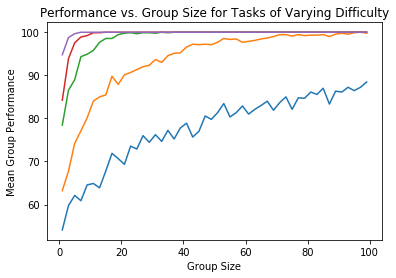

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  2 00:42:50 2018

This file inputs a dataframe created by virtual_groups.py and graphs
the results.

There are 20 different lines we could plot. Let's pull out 5 representative ones
On Q12 accuracy rate for individuals was 75.24 % **plot this
On Q17 accuracy rate for individuals was 55.82 % **plot this
On Q18 accuracy rate for individuals was 93.81 % **plot this
On Q19 accuracy rate for individuals was 85.41 % **plot this
On Q20 accuracy rate for individuals was 63.47 % **plot this

@author: James Kajdasz
"""
#lets open up our dataframe
df = pd.read_csv('Nominal_Group_Data.csv', low_memory=False)

# There are 20 different lines we could plot. Let's pull out 5 good ones
# duplicating _group_size column so we can use it later
df['size'] = df['group_size'] 

# On Q17 accuracy rate for individuals was 55.82 %
Q17_check = df['difficulty'] == 55.82 
df_Q17 = df[Q17_check] 
means_Q17 = df_Q17.groupby('group_size').mean()
Q17_size = means_Q17['size']
Q17_perf = means_Q17['sample_performance']

# On Q20 accuracy rate for individuals was 63.47 % **plot this
Q20_check = df['difficulty'] == 63.47 
df_Q20 = df[Q20_check] 
means_Q20 = df_Q20.groupby('group_size').mean()
Q20_size = means_Q20['size']
Q20_perf = means_Q20['sample_performance']

# On Q12 accuracy rate for individuals was 75.24 %
Q12_check = df['difficulty'] == 75.24 
df_Q12 = df[Q12_check] 
means_Q12 = df_Q12.groupby('group_size').mean()
Q12_size = means_Q12['size']
Q12_perf = means_Q12['sample_performance']

# On Q19 accuracy rate for individuals was 85.41 %
Q19_check = df['difficulty'] == 85.41 
df_Q19 = df[Q19_check] 
means_Q19 = df_Q19.groupby('group_size').mean()
Q19_size = means_Q19['size']
Q19_perf = means_Q19['sample_performance']

# On Q18 accuracy rate for individuals was 93.81 %
Q18_check = df['difficulty'] == 93.81 
df_Q18 = df[Q18_check] 
means_Q18 = df_Q18.groupby('group_size').mean()
Q18_size = means_Q18['size']
Q18_perf = means_Q18['sample_performance']


# Let's plot our lines
plt.plot(Q17_size, Q17_perf, Q20_size, Q20_perf, Q12_size, Q12_perf, 
         Q19_size, Q19_perf, Q18_size, Q18_perf)

plt.xlabel('Group Size')
plt.ylabel('Mean Group Performance')
plt.title('Performance vs. Group Size for Tasks of Varying Difficulty')
plt.show()


### Modeling Performance predicted by group size and task difficulty
Next, we'll regress performance on to group size and task difficulty. We are also hypothesizing an interaction term, and based on the curvilinear graphs, it appears we should add a squared term as well.

In [6]:
# Format X and Y variables
array = df_samples.values
X = array[:,1:6]
Y = np.array(df_samples['sample_performance'])

# Run Regression
reg = LinearRegression().fit(X,Y)


In [7]:
# Calculate R Squared: 
reg.score(X,Y)

0.7431923196998664

### Prediction Model
We have a model. We can re-write the model so we can provide guidance on how big a group should be based on desired accuracy and difficulty of task.

In [8]:
# Set model weights
w0 = reg.intercept_
w1 = reg.coef_[0] # Difficulty
w2 = reg.coef_[1] # Group Size
w3 = reg.coef_[2] # Diff * GrpSiz
w4 = reg.coef_[3] # Diff Sq
w5 = reg.coef_[4] # Siz Sq

# Request user enter difficulty of the task
x1 = float(input('What accuracy rate do individuals have on this task? (enter number from 0 to 100) '))
x4 = x1*x1
Acc = float(input('What accuracy rate do you want to achieve on this task? (enter number 0-100) '))

# Iterate to find necessary group size
x2 = 1
PrevAcc = 0
if x1 <= 50:
    print("No group size will help performance. The wisdom of the crowds only works if individual")
    print("performance is greater than 50%")
else:
    while x2:
        x3 = x1*x2 
        x5 = x2*x2
        ObsAcc = w0 + w1*x1 + w2*x2 + w3*x3 + w4*x4 + w5*x5
        if ObsAcc > Acc:
            print("Your crowd needs to have at least ",x2," people to acheive ",Acc,"% accuracy.")
            break
        elif ObsAcc < PrevAcc:
            print("The best estimate I can come up with is ",x2," people to acheive ",Acc,"% accuracy.")
            break
        else:
            PrevAcc = ObsAcc
            #print("Group Size: ",x2,"   Accuracy: ",ObsAcc)
            x2 += 2
            
            
    

What accuracy rate do individuals have on this task? (enter number from 0 to 100) 70
What accuracy rate do you want to achieve on this task? (enter number 0-100) 90
Your crowd needs to have at least  19  people to acheive  90.0 % accuracy.
